In [1]:
# Import basic packages
import numpy as np
import pandas as pd
import scipy.stats as stats
# Import data processing package
from DataProcessing import *
# Import plot packages
import gspplot
from gspplot import *
# Import graph packages
import gsp
from pygsp import graphs, filters, plotting, utils
# Import other packages
from Learning import *
from operator import itemgetter
import warnings; warnings.filterwarnings('ignore')

# 1  Data Processing

## 1.1 Read Data and Crop a Patch

In [2]:
path_cloud  = 'data/Vaihingen3D_Traininig.pts'
# Load dataset as pandas dataframe
cloud       = load_cloud(path_cloud)
newcloud    = cloud_preprocess(cloud)
# Crop a patch from cloud
patch2      = crop_patch(newcloud, (200, 350), (50 , 200))

-------------------- Load Data ---------------------
Data Loading...
=> Done.
----------------------------------------------------
--------------- Data Pre-Processing ----------------
Drop duplicates...
=> Duplicates #: 40946, Ratio: 5.43% of the dataset.
Re-center the data...
=> Done.
----------------------------------------------------
-------------------- Crop Patch --------------------
Crop the patch...
=> Crop a patch from: x:[200, 350], y:[50, 200].
=> Points left for patch: 182404.
----------------------------------------------------


## 1.2 Data Visualization

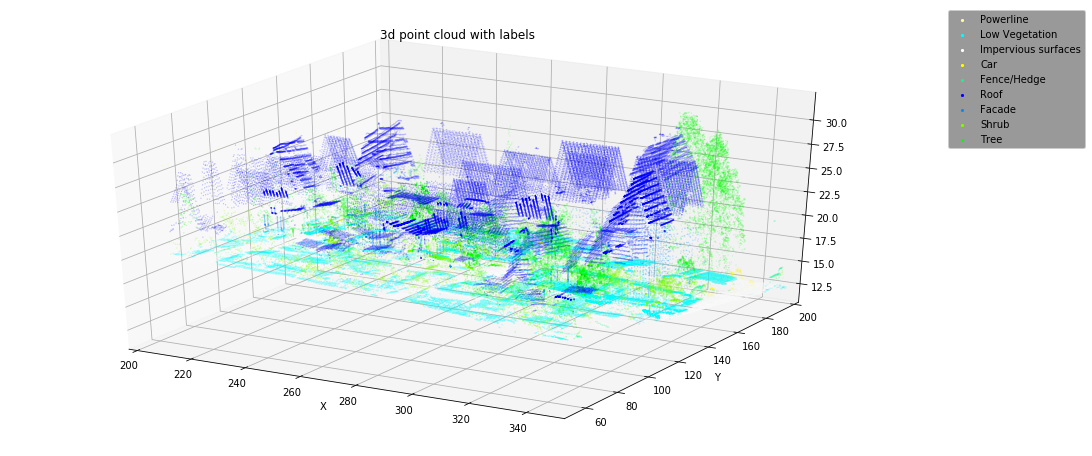

In [3]:
plot_graph_3D(patch2, 
              figsize=(16, 8), 
              marksize=0.02, 
              markerscale=15, 
              xRange=(200, 350), 
              yRange=(50 , 200))

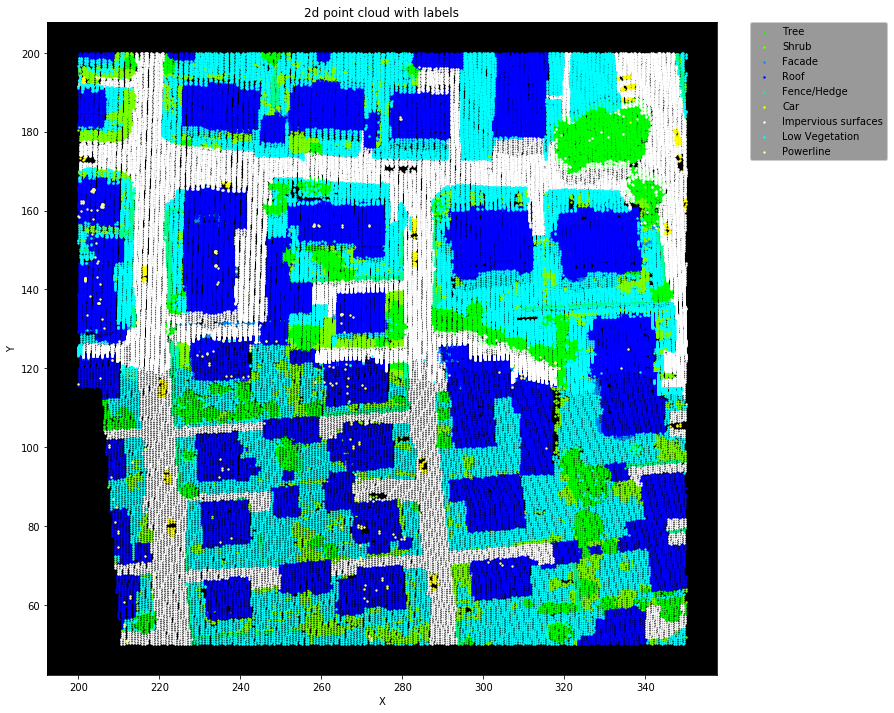

In [4]:
plot_graph_2D(patch2, 
              figsize=(12,12), 
              marksize=2,
              markerscale=1)

In the upper part, there exist two scanning directions and we have denser points, while in the lower part, there is only one scanning direction and we also have fewer points. 

# 2 Graph Construction 

## 2.1 Generating Graph

Five types of graph are generated in the following way:  
1) When type is '30nn', connect 30 nearest neighbors of a particular node.  
2) When type is 'r101', connect neighbors within the radius of 1.1.  

Then, it remains to calculate the weights:  
1) Gaussian: Use Euclidean distance. Weight is calculated by: $$\mathbf{W}(u,v) = \exp \left( \frac{-d^2(u, v)}{2\sigma^2} \right)$$  
Where $\sigma$ is the mean value of all distances.

2) Binary: Set all weights to be 1 if connected.

3) Local: Comparing to Gaussian, only $\sigma$ changes here.$$\mathbf{W}(u,v) = \exp \left( \frac{-d^2(u, v)}{\sigma_i \sigma_j} \right)$$  
Where $\sigma_i$ is the distance between node i and its farthest neighbor, the same for node j.



### Use the Number of Neighbors

In [5]:
# 30nn, Gaussian kernel
G_30nn_Gaussain2 = gsp.knn_graph(cloud=patch2[['x', 'y', 'z']], k=30, dist3D=False, 
                                 mode='distance', neightype='number', lap_type='combinatorial')
# 30nn, Binary graph
G_30nn_Binary2   = gsp.knn_graph(cloud=patch2[['x', 'y', 'z']], k=30, dist3D=False, 
                                 mode='connectivity', neightype='number', lap_type='combinatorial')
# 30nn, Local scaling
G_30nn_Local2    = gsp.knn_graph(cloud=patch2[['x', 'y', 'z']], k=30, dist3D=False, 
                                 mode='local', neightype='number', lap_type='combinatorial')

### Use the Radius to Find Neighbors

In [6]:
# r1.1, Gassian kernel
G_r101_Gaussain2 = gsp.knn_graph(cloud=patch2[['x', 'y', 'z']], r=1.1, dist3D=False, 
                                 mode='distance', neightype='radius', lap_type='combinatorial')
# r1.1, Binary graph
G_r101_Binary2   = gsp.knn_graph(cloud=patch2[['x', 'y', 'z']], r=1.1, dist3D=False, 
                                 mode='connectivity', neightype='radius', lap_type='combinatorial')

## 2.2  Gaussian Kernel Visualization

In [7]:
# Compute a list of distances 
W_30nn_Gaussain2, dists1  = gsp.knn_w(cloud=patch2[['x', 'y', 'z']], k=30, dist3D=False, 
                                      mode='distance', neightype='number')
_, dists2                 = gsp.knn_w(cloud=patch2[['x', 'y', 'z']], r=1.1, dist3D=False, 
                                      mode='distance', neightype='radius')

# Compute minimum and maximum distance with neighbors
dists1, dists2 = np.array(dists1), np.array(dists2)
s1, s2         = np.mean(dists1[dists1!=0]), np.mean(dists2[dists2!=0])
d_max1, d_max2 = np.max(dists1), 1.1
d_min1, d_min2 = np.min(dists1), np.min(dists1)

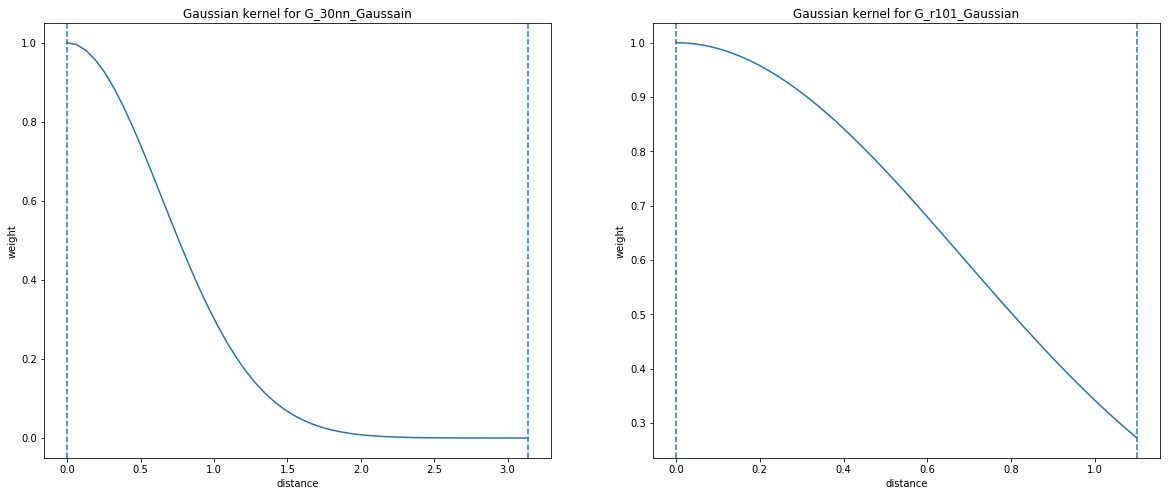

In [8]:
# Visualize weights wrt distance of different kernels
fig = plt.figure(figsize=(20, 8))

# Gaussian kernel with 30 nearest neighbours
ax1 = fig.add_subplot(121)
x1 = np.linspace(d_min1, d_max1, 50)
y1 = s1*np.sqrt(2*np.pi)*stats.norm.pdf(x1, 0, s1)
ax1.plot(x1, y1)
ax1.set_xlabel('distance')
ax1.set_ylabel('weight')
ax1.axvline(x=d_min1, linestyle='--')
ax1.axvline(x=d_max1, linestyle='--')
ax1.set_title("Gaussian kernel for G_30nn_Gaussain")

# Gaussian kernel with radius 1.1
ax2 = fig.add_subplot(122)
x2 = np.linspace(d_min1, d_max2, 50)
y2 = s2*np.sqrt(2*np.pi)*stats.norm.pdf(x2, 0, s2)
ax2.plot(x2, y2)
ax2.set_xlabel('distance')
ax2.set_ylabel('weight')
ax2.axvline(x=d_min2, linestyle='--')
ax2.axvline(x=d_max2, linestyle='--')
ax2.set_title("Gaussian kernel for G_r101_Gaussian")

plt.show()

# 3 POI detection

## 3.1 Mexican Hat Filter Construction

In [9]:
# Create graph dictionary
graph_list = [G_30nn_Gaussain2, G_30nn_Binary2, G_30nn_Local2,
              G_r101_Gaussain2, G_r101_Binary2]

# Initialize filters dictionary
filter_key = ['g_MH_30nn_Gaussain', 'g_MH_30nn_Binary', 'g_MH_30nn_Local', 
              'g_MH_r101_Gaussain', 'g_MH_r101_Binary']
filter_dict = dict.fromkeys(filter_key)
for i, idx in zip(filter_dict.keys(), range(5)):
    if 'nn' in i:
        filter_dict[i] = filters.MexicanHat(graph_list[idx], Nf=1+len([0.04]), lpfactor=1, scales=[0.04])
    else:
        filter_dict[i] = filters.MexicanHat(graph_list[idx], Nf=1+len([0.004]), lpfactor=1, scales=[0.004])

## 3.2 Visualization Filters

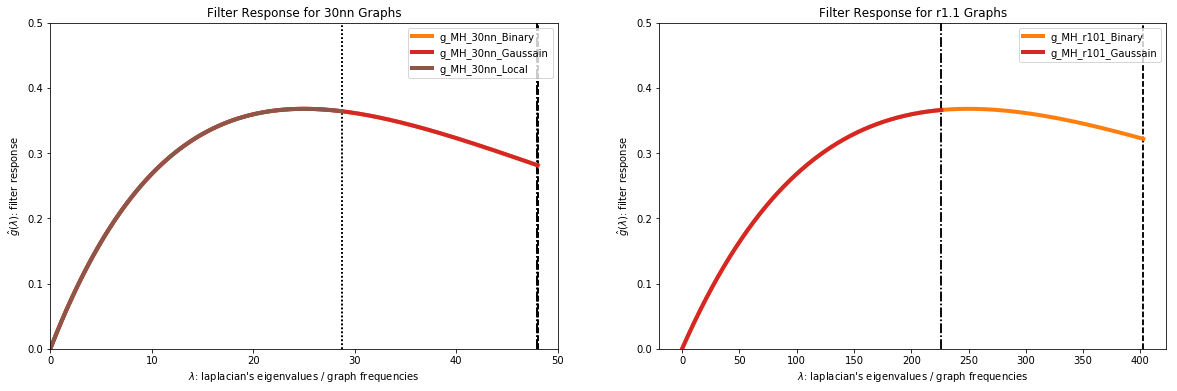

In [10]:
fig = plt.figure(figsize=(20, 6))

# Visualize filters constructed using number of Neighbors
ax1 = fig.add_subplot(121)
for i,j in zip(itemgetter(*[1, 0, 2])(list(filter_dict.keys())), range(3)):
    filter_dict[i].plot(ax=ax1, show_sum=False)
    ax1.lines.pop(j)
    ax1.set_xlim(0, 50)
    ax1.set_ylim(0, 0.5)
    ax1.vlines(G_30nn_Binary2.lmax, 0, 0.5, 'k', '--')
    ax1.vlines(G_30nn_Gaussain2.lmax, 0, 0.5, 'k', '-.')
    ax1.vlines(G_30nn_Local2.lmax, 0, 0.5, 'k', ':')
    ax1.set_title("Filter Response for 30nn Graphs")
    ax1.legend(itemgetter(*[1, 0, 2])(list(filter_dict.keys())))

# Visualize filters constructed using radius to find neighbors
ax2 = fig.add_subplot(122)
for i,j in zip(itemgetter(*[4, 3])(list(filter_dict.keys())), range(2)):
    filter_dict[i].plot(ax=ax2, show_sum=False)
    ax2.lines.pop(j)
    #ax2.set_xlim(0, 120)
    ax2.set_ylim(0, 0.5)
    ax2.vlines(G_r101_Binary2.lmax, 0, 0.5, 'k', '--')
    ax2.vlines(G_r101_Gaussain2.lmax, 0, 0.5, 'k', '-.')
    ax2.set_title("Filter Response for r1.1 Graphs")
    ax2.legend(itemgetter(*[4, 3])(list(filter_dict.keys())))

plt.show()    

## 3.3 POI Detection and Visualization

In [11]:
threshold_nn = [0.2, 0.2, 0.2]
threshold_r = [0.05, 0.1]
# Create signal dictionary
signal_dict = dict.fromkeys(['s_30nn_Gaussain', 's_30nn_Binary', 's_30nn_Local',
                             's_r101_Gaussain', 's_r101_Binary'])

# Create edge index dictonary, highlight nodes that have high frequency
edge_dict = dict.fromkeys(['edgeind_30nn_Gaussain', 'edgeind_30nn_Binary', 'edgeind_30nn_Local',
                           'edgeind_r101_Gaussain', 'edgeind_r101_Binary'])
for i, j, k, m in zip(signal_dict.keys(), filter_dict.keys(), edge_dict.keys(), range(5)):
    signal_dict[i] = filter_dict[j].filter(patch2.z, method = 'chebyshev')
    if 'nn' in i:
        edge_dict[k] = signal_dict[i][:, -1] >= threshold_nn[m]
    else:
        edge_dict[k] = signal_dict[i][:, -1] >= threshold_r[m-3]

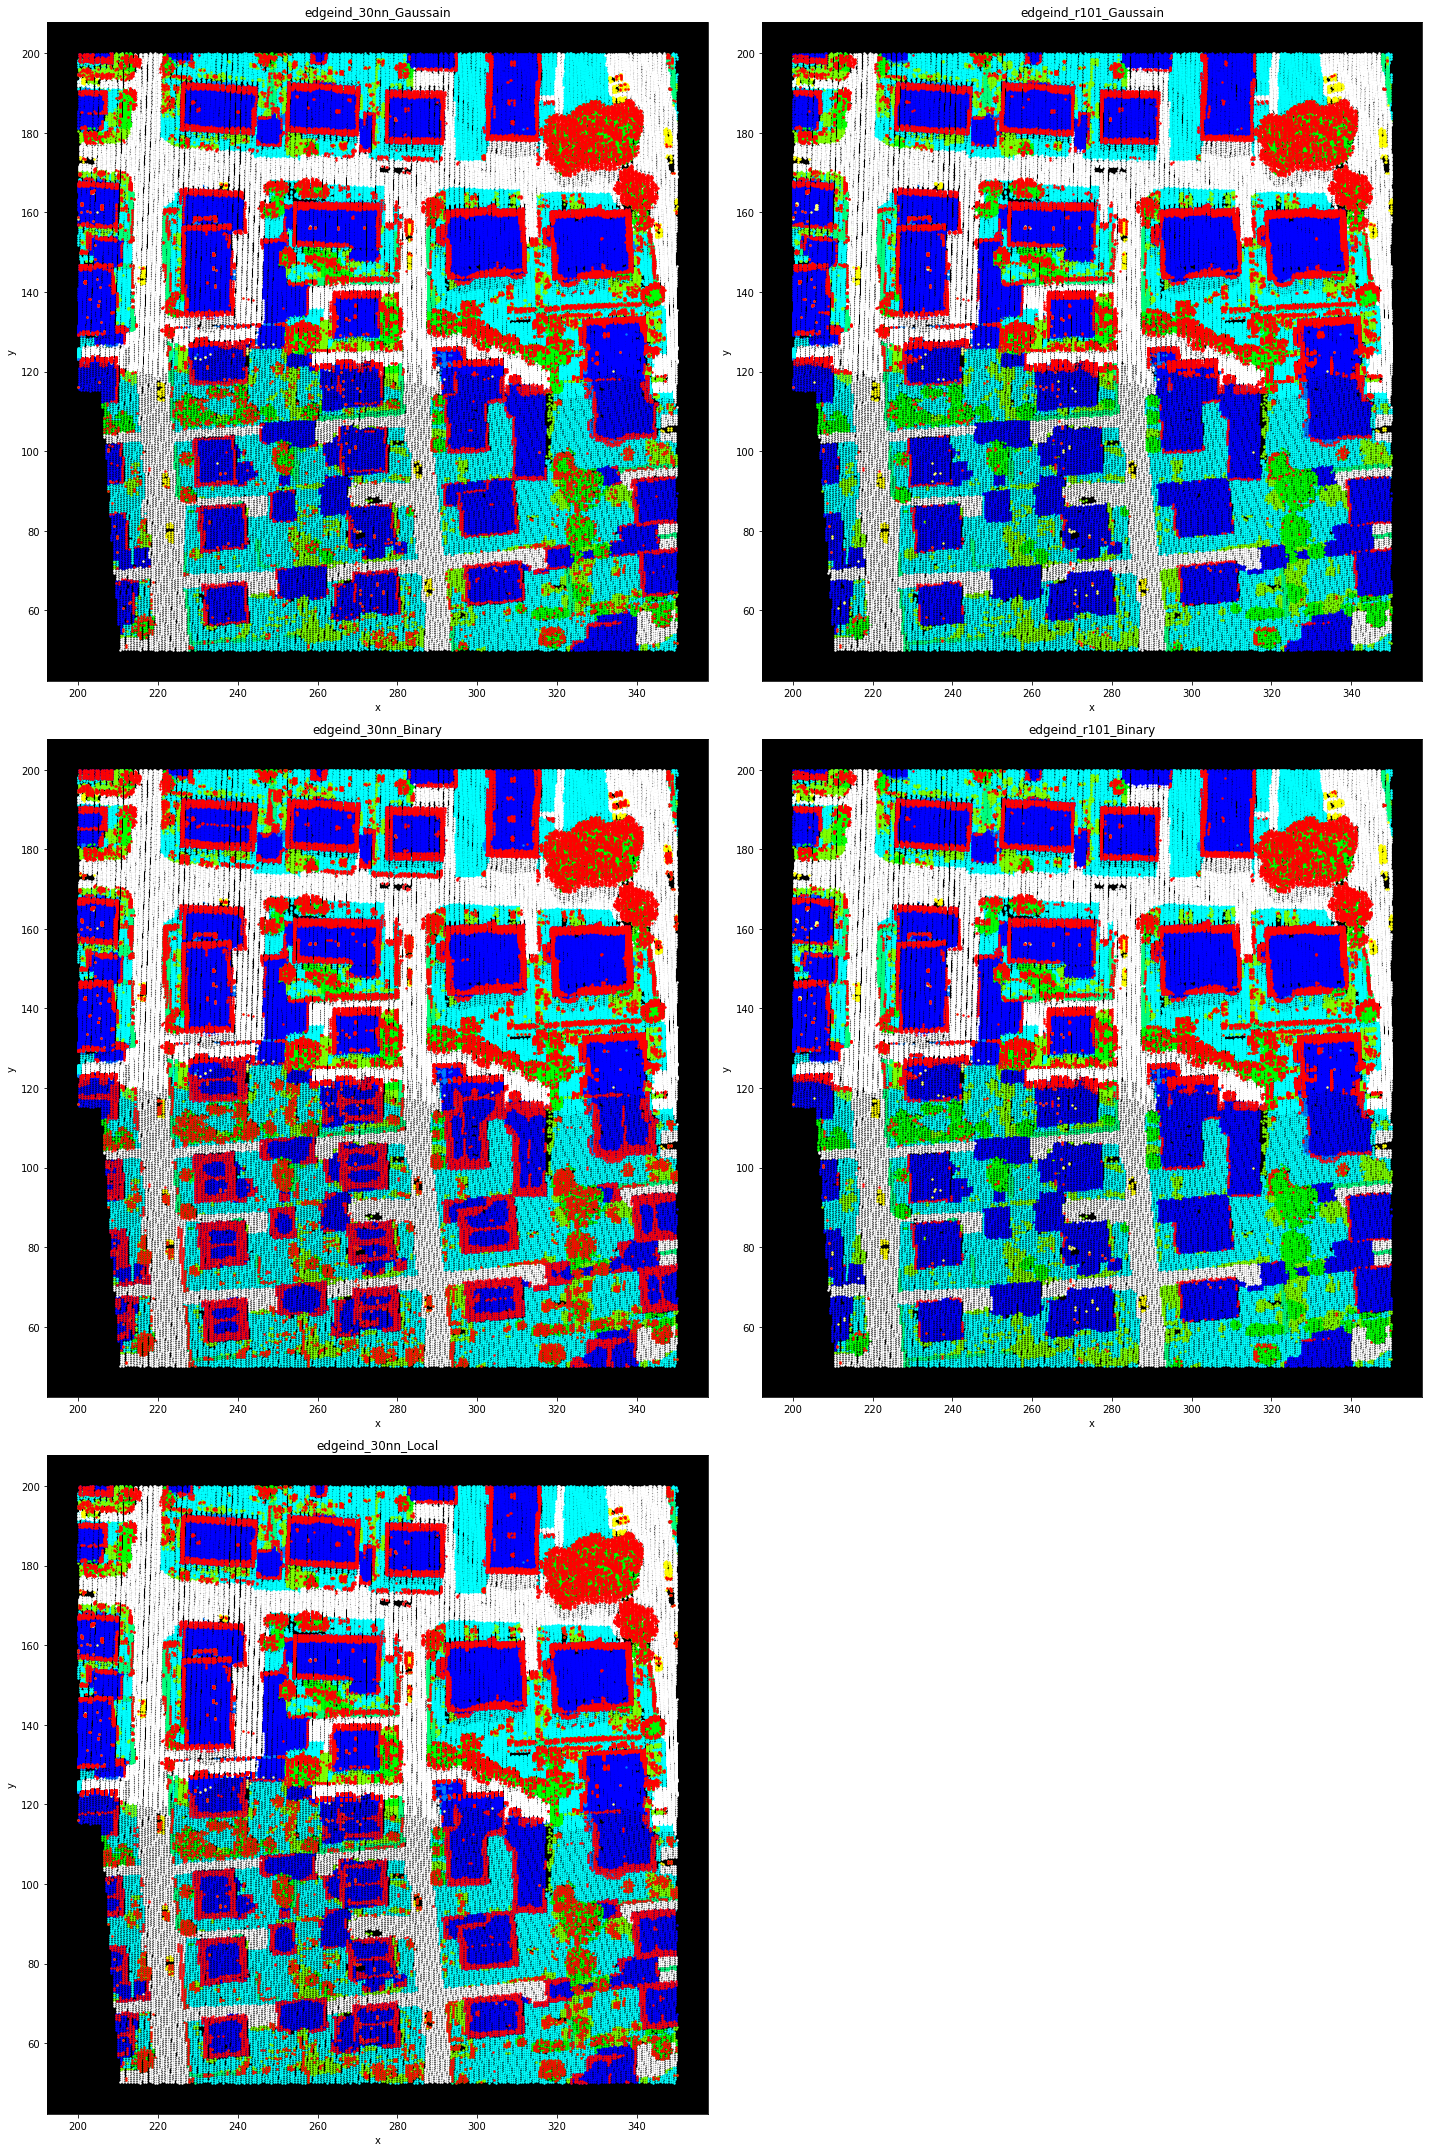

In [12]:
plt.figure(figsize=(20,30))
axes = []
for i in range(5):
    axes.append(plt.subplot2grid((3,2), (i%3, int(i/3)), colspan=1))
for i, j in zip(edge_dict.keys(), axes):               
    if 'nn' in i:
        gspplot.plot_vaihingen_2D(patch2, 
                                  id_highlight=np.nonzero(edge_dict[i])[0], 
                                  ax=j,
                                  label_high='Edges',
                                  title="{}".format(i))
    else:
        gspplot.plot_vaihingen_2D(patch2, 
                                  id_highlight=np.nonzero(edge_dict[i])[0], 
                                  ax=j, 
                                  label_high='Edges',
                                  title="{}".format(i))
plt.tight_layout()

As shown, 30nn Binary graph and 30nn local graph can cure unequal point density, while other types of graphs are sensitive to it.

## 3.3 Setting Ground Truth

I use the 30nn Binary graph to prepare for the ground truth. The signal value of the building nodes is 1, while that of other nodes is 0.

It is noticed that some points in the body of the buildings come out. They seem to surround the powerline points. So I do the following procedures: 1) If the nodes belong to roofs or powerlines, set the signal to be 1. 2) Remove the positive false points after filtering the signal. We cannot delete those powerline points in the dataframe because the indices are changed in this way. 

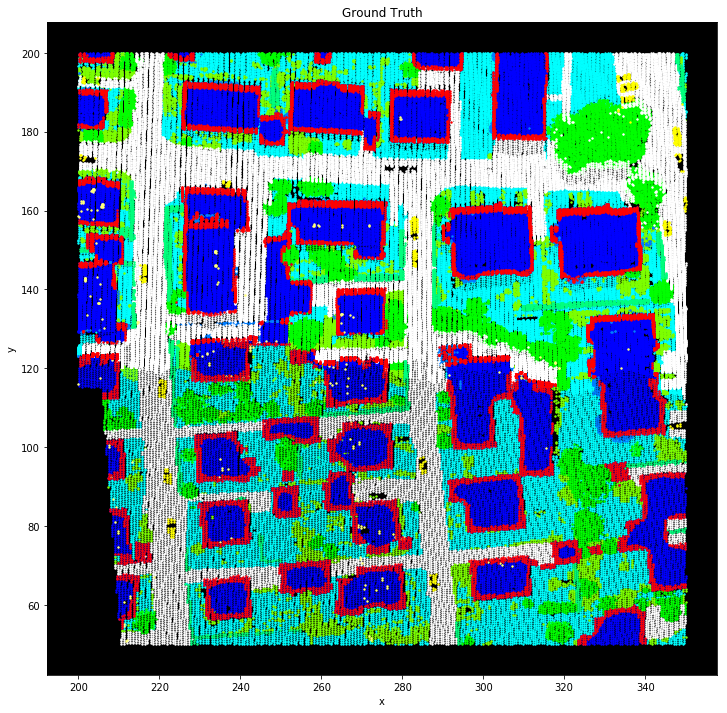

In [13]:
df2, edge_roof = set_ground_truth(patch=patch2, threshold=0.08, f=filter_dict['g_MH_30nn_Binary'], figsize=(12, 12))

## 3.4 Graph Quantitative Comparison

The table below shows what the highligted points are composed of in each type of the graph. The column named total calculte the total number of points that come out after filtering in each graph representation. Other columns like precision and recall are calculated in the following way:

Precision = $\frac{detected\ points\ \cap \ GT}{detected\ points}$  
Recall (reference to ground truth) = $\frac{detected\ points\ \cap \ GT}{GT}$  
Recall (reference to label) = $\frac{detected\ points\ \cap \ roof points}{roof\ points}$

In [14]:
qua_comp_df(df =comp_df(patch2, edge_dict=edge_dict, labels=labels),
            df2=df2,
            edge_roof=edge_roof, 
            edge_dict=edge_dict)

Powerline  Low Vegetation  Impervious surfaces       Car  \
30nn_Binary     0.005470        0.016098             0.002032  0.009221   
30nn_Local      0.006421        0.015416             0.002384  0.005976   
30nn_Gaussain   0.007061        0.013094             0.000781  0.002768   
r101_Gaussain   0.005629        0.008780             0.000496  0.001062   
r101_Binary     0.005534        0.006235             0.000332  0.001070   

               Fence/Hedge      Roof    Facade     Shrub      Tree  Total  \
30nn_Binary       0.045427  0.512516  0.033550  0.096429  0.279258  38391   
30nn_Local        0.039827  0.473253  0.043196  0.107403  0.306125  31461   
30nn_Gaussain     0.035237  0.479330  0.044853  0.094887  0.321990  28181   
r101_Gaussain     0.029667  0.500266  0.055404  0.082310  0.316388  28247   
r101_Binary       0.027190  0.525825  0.051428  0.070169  0.312219  27106   

               Precision  Recall_GT  Recall_roof  
30nn_Binary     0.329296   0.853324     0.332685  
30nn_Local      0.370300   0.786365     0.251746  
30nn_Gaussain   0.381782   0.726223     0.228396  
r101_Gaussain   0.328141   0.625650     0.238929  
r101_Binary     0.337269   0.617077     0.240992

The Precision column seems to give the completely opposite conclusion compared to the Recall_GT column. That is, when the Recall_GT rate is higher, we have less precision. This may seems a little confusing at first look. But when we look at the total points each type of graph has detected, we find that more points in total tend to leads to less precision. That explain this phenomenon.

# 4 Controling Gaussian Scaling parameter

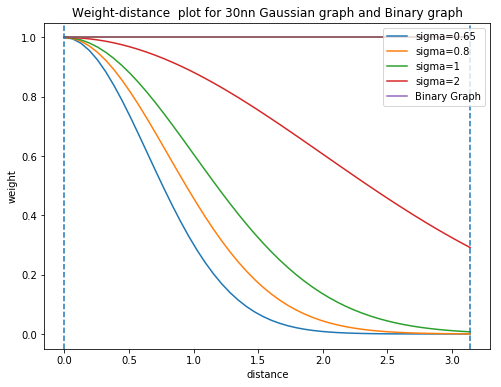

In [15]:
fig = plt.figure(figsize=(8, 6))
s   = [s1, 0.8, 1, 2]
x1  = np.linspace(d_min1, d_max1, 50)
for i in range(len(s)):
    y1 = s[i]*np.sqrt(2*np.pi)*stats.norm.pdf(x1, 0, s[i])
    plt.plot(x1, y1)
y1 = [1 for i in range(len(x1))]

# Visualize weight-distance plot of different parameters
plt.plot(x1, y1)
plt.xlabel('distance')
plt.ylabel('weight')
plt.plot(x1, y1)
plt.axvline(x=d_min1, linestyle='--')
plt.axvline(x=d_max1, linestyle='--')
plt.legend(('sigma={:.2f}'.format(s1), 
            'sigma={}'.format(s[1]), 
            'sigma={}'.format(s[2]), 
            'sigma={}'.format(s[3]), 
            'Binary Graph'),
           loc='upper right')
plt.title("Weight-distance  plot for 30nn Gaussian graph and Binary graph")
plt.show()

For 30nn Gaussian Graph, edges are less weighted in sparse areas than in dense areas, make it harder to capture depth change. To substantiate this idea, we change $\sigma$ value in the weight expression of Gaussian graph. By increasing $\sigma$, we can make Gaussian graph behave more like a binary graph and the edge weight decreased more slowly when increasing the distance as shown in the figure\.

In [16]:
# Create gaussain graphs using different scaling parameters
G_30nn_Gaussain_sigma2 = gsp.knn_graph(cloud=patch2[['x', 'y', 'z']], k=30, dist3D=False, mode='distance', 
                                       neightype='number', lap_type='combinatorial', sigma=s[1])
G_30nn_Gaussain_sigma4 = gsp.knn_graph(cloud=patch2[['x', 'y', 'z']], k=30, dist3D=False, mode='distance', 
                                       neightype='number', lap_type='combinatorial', sigma=s[2])
G_30nn_Gaussain_sigma6 = gsp.knn_graph(cloud=patch2[['x', 'y', 'z']], k=30, dist3D=False, mode='distance', 
                                       neightype='number', lap_type='combinatorial', sigma=s[3])

In [17]:
# Compute points of interest on different graphs
graph_list2  = [G_30nn_Gaussain2, G_30nn_Gaussain_sigma2, G_30nn_Gaussain_sigma4,
                G_30nn_Gaussain_sigma6, G_30nn_Binary2]
filter_dict2 = dict.fromkeys(['30nn_Gaussain_mean', '30nn_Gaussain_sigma2', '30nn_Gaussain_sigma4', 
                              '30nn_Gaussain_sigma6', '30nn_Binary'])
for i, idx in zip(filter_dict2.keys(), range(5)):
    filter_dict2[i] = filters.MexicanHat(graph_list2[idx], Nf=1+len([0.04]), lpfactor=1, scales=[0.04])

threshold_nn2 = [0.2, 0.2, 0.2, 0.2, 0.2]
# Create signal dictionary
signal_dict2  = dict.fromkeys(['s_30nn_Gaussain_mean', 's_30nn_Gaussain_sigma2', 's_30nn_Gaussain_sigma4',
                               's_30nn_Gaussain_sigma6', 's_30nn_Binary'])

# Create edge index dictonary, highlight nodes that have high frequency
edge_dict2 = dict.fromkeys(['edgeind_30nn_Gaussain_mean', 'edgeind_30nn_Gaussain_sigma2', 'edgeind_30nn_Gaussain_sigma4', 
                            'edgeind_30nn_Gaussain_sigma6', 'edgeind_30nn_Binary'])
for i, j, k, m in zip(signal_dict2.keys(), filter_dict2.keys(), edge_dict2.keys(), range(5)):
    signal_dict2[i] = filter_dict2[j].filter(patch2.z, method = 'chebyshev')
    edge_dict2[k]   =  signal_dict2[i][:, -1] >= threshold_nn2[m]

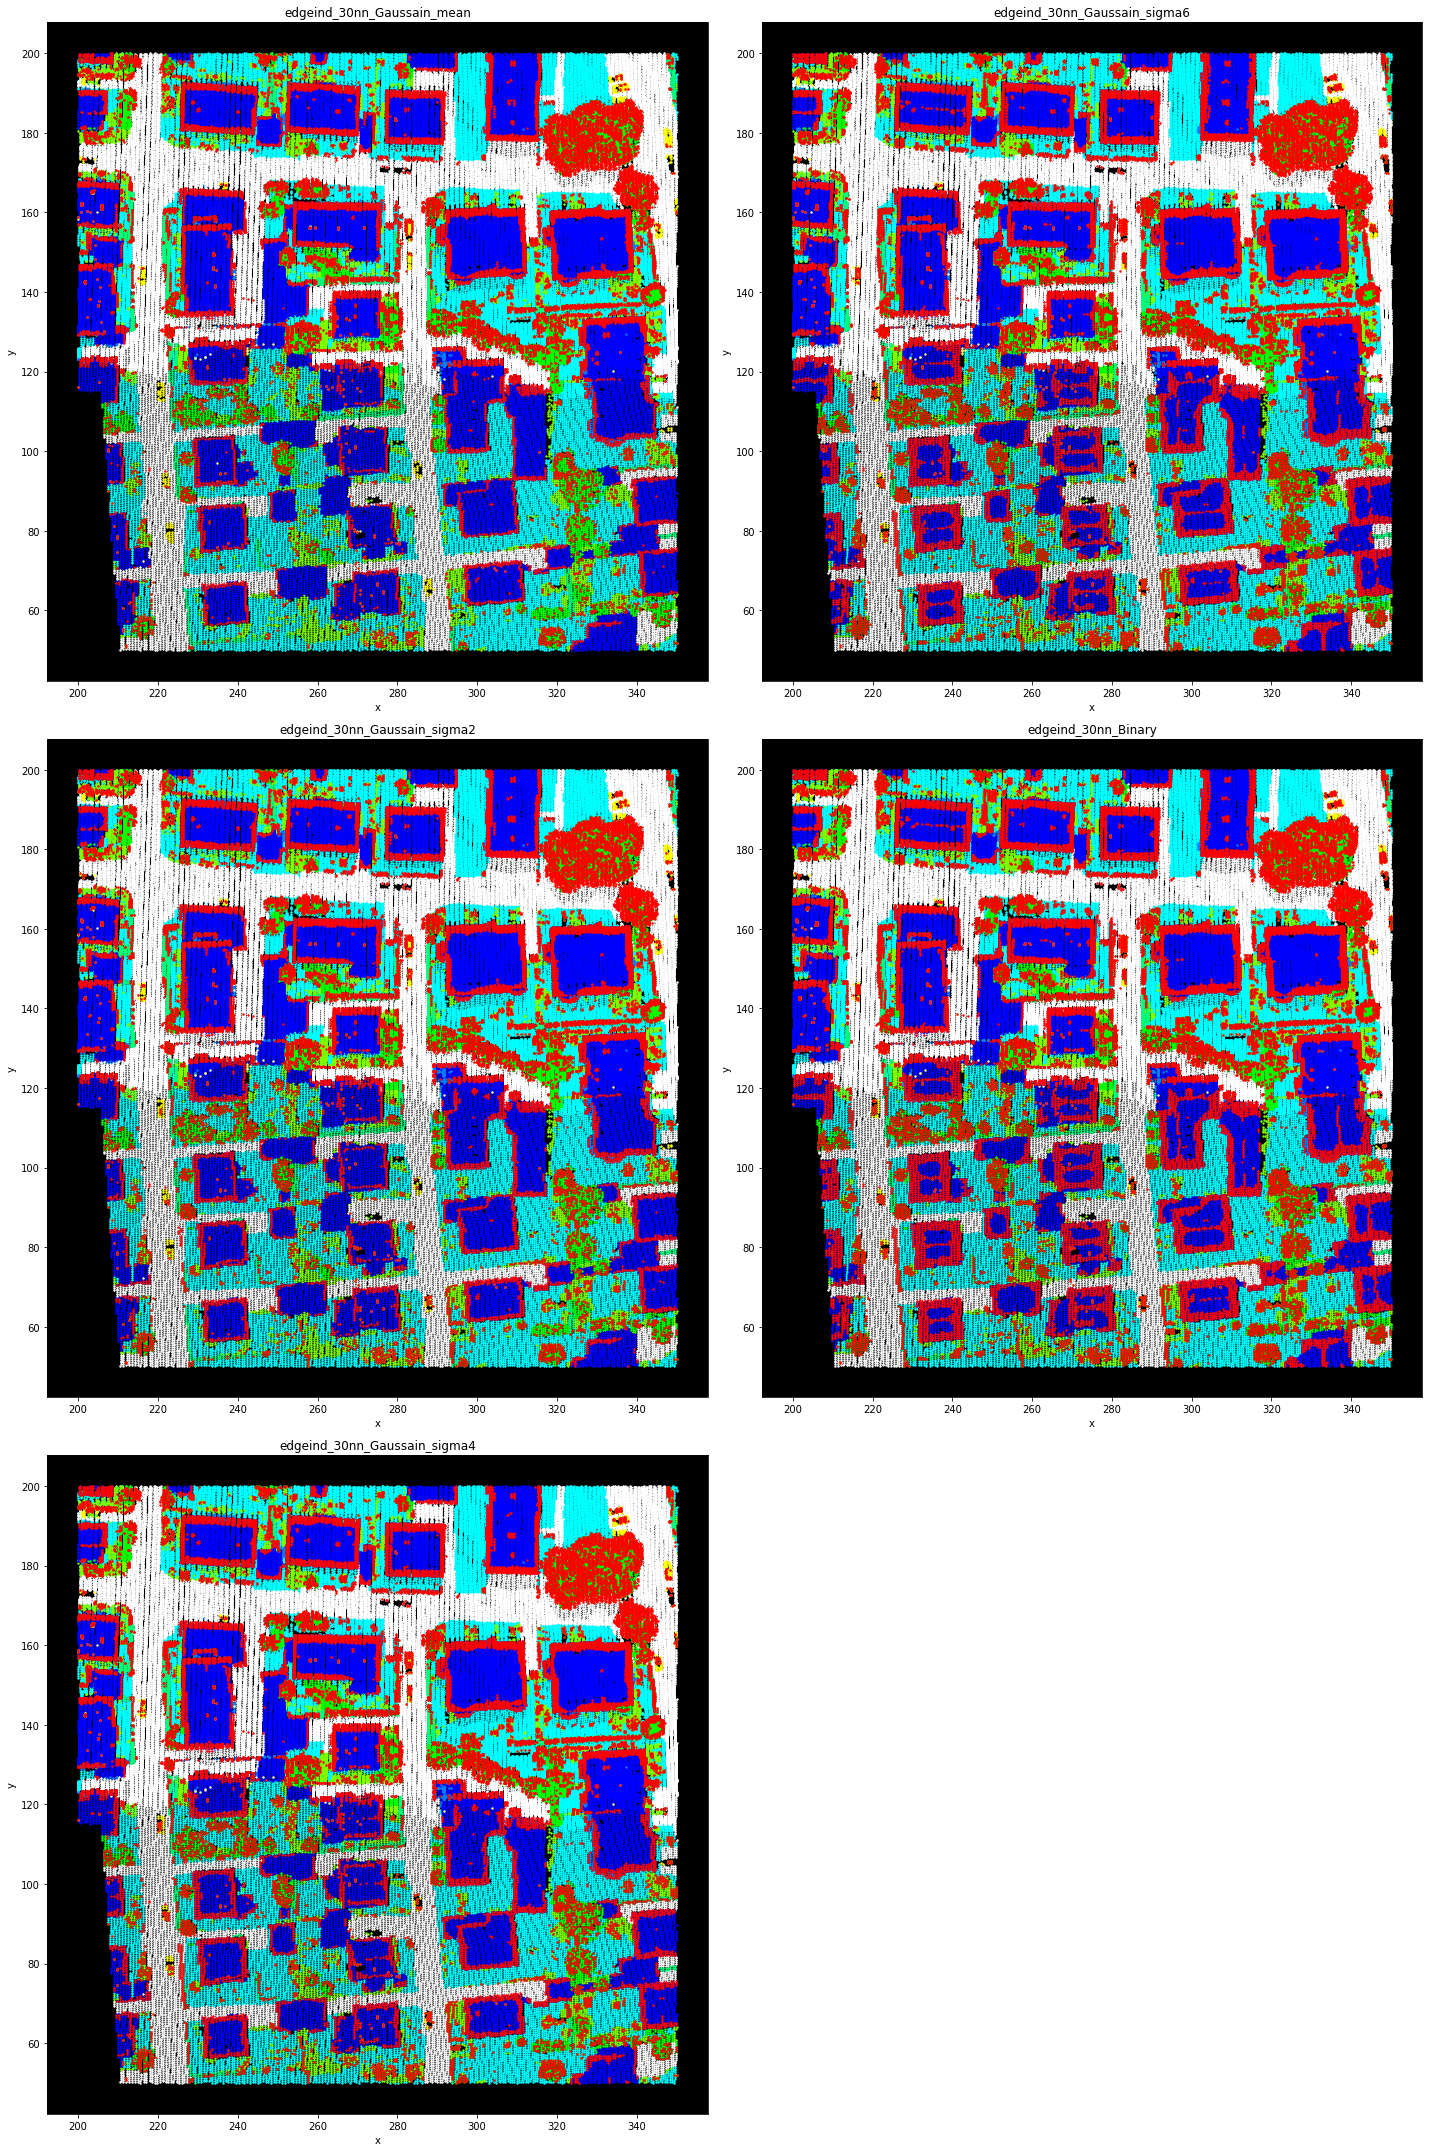

In [18]:
# Visulize the outcomes
plt.figure(figsize=(20,30))
axes = []
for i in range(5):
    axes.append(plt.subplot2grid((3,2), (i%3, int(i/3)), colspan=1))
for i, j in zip(edge_dict2.keys(), axes):              
    gspplot.plot_vaihingen_2D(patch2, 
                              id_highlight=np.nonzero(edge_dict2[i])[0], 
                              ax=j, 
                              label_high='Edges',
                              title="{}".format(i))
plt.tight_layout()

In [19]:
qua_comp_df(df =comp_df(patch2, edge_dict=edge_dict2, labels=labels),
            df2=df2,
            edge_roof=edge_roof, 
            edge_dict=edge_dict2)

Powerline  Low Vegetation  Impervious surfaces  \
30nn_Binary            0.005470        0.016098             0.002032   
30nn_Gaussain_sigma6   0.005610        0.016455             0.002067   
30nn_Gaussain_sigma4   0.006124        0.016596             0.002219   
30nn_Gaussain_sigma2   0.006567        0.015472             0.001506   
30nn_Gaussain_mean     0.007061        0.013094             0.000781   

                           Car  Fence/Hedge      Roof    Facade     Shrub  \
30nn_Binary           0.009221     0.045427  0.512516  0.033550  0.096429   
30nn_Gaussain_sigma6  0.008993     0.045689  0.502497  0.034414  0.099780   
30nn_Gaussain_sigma4  0.007751     0.043959  0.482014  0.037717  0.104662   
30nn_Gaussain_sigma2  0.005221     0.039849  0.477929  0.040650  0.102633   
30nn_Gaussain_mean    0.002768     0.035237  0.479330  0.044853  0.094887   

                          Tree  Total  Precision  Recall_GT  Recall_roof  
30nn_Binary           0.279258  38391   0.329296   0.853324     0.332685  
30nn_Gaussain_sigma6  0.284495  37252   0.336653   0.846507     0.316504  
30nn_Gaussain_sigma4  0.298959  33804   0.356023   0.812352     0.275502  
30nn_Gaussain_sigma2  0.310174  31218   0.368153   0.775768     0.252270  
30nn_Gaussain_mean    0.321990  28181   0.381782   0.726223     0.228396

From table, we can see that the recall rate increases with the increase of $\sigma$ value. When $\sigma$ equals 6, the recall rate of Gaussian graph is very close that of the binary graph. 